In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/133272
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

In [4]:
# linear regression model possible to use for version 3 of the feature group
# but it yields a lower accuracy than the gradient boosting classifier (0.51 instead of 0.66)
# resource: https://www.kaggle.com/code/rohanchopade/wine-quality-prediciton-using-linear-regression

In [5]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

k_neighbors = range(2 , 11 , 2)
Training_acc = []
Testing_acc = []

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
for i in k_neighbors:
    
    model = KNeighborsClassifier(n_neighbors= i)
    model.fit(X_train , y_train)
    Training_acc.append(model.score(X_train , y_train))
    Testing_acc.append(model.score(X_test , y_test))
    
print(f'Training accuracy: f{Training_acc}')
print(f'Testing accuracy: f{Testing_acc}')

Finished: Reading data from Hopsworks, using ArrowFlight (1.86s) 


Training accuracy: f[0.8264872521246459, 0.7719546742209632, 0.7422096317280453, 0.7355996222851747, 0.7275731822474032]
Testing accuracy: f[0.5939565627950897, 0.6421152030217187, 0.6449480642115203, 0.6543909348441926, 0.6657223796033994]


In [6]:
clf = GradientBoostingClassifier(random_state= 42)

params = {
    'n_estimators': range(25 , 125 , 25),
    'max_depth': range(3 , 45 , 10)
}
params

gbc = GridSearchCV(
    clf,
    param_grid= params,
    cv= 5,
    n_jobs=-1,
    verbose=1
)
gbc

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 45, 10),
                         'n_estimators': range(25, 125, 25)},
             verbose=1)

In [7]:
gbc.fit(X_train , y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteocirca/opt/anaconda3/envs/smldl/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 45, 10),
                         'n_estimators': range(25, 125, 25)},
             verbose=1)

In [8]:
cv_results = pd.DataFrame(gbc.cv_results_)
cv_results.sort_values(by= 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.630025,0.017859,0.003301,0.000081,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.781840,0.753247,0.748524,0.772137,0.759150,0.762979,0.012312,1
2,0.474398,0.015529,0.004442,0.002535,3,75,"{'max_depth': 3, 'n_estimators': 75}",0.777123,0.752066,0.749705,0.767414,0.755608,0.760383,0.010350,2
1,0.297590,0.012882,0.003043,0.000320,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.771226,0.743802,0.743802,0.767414,0.754427,0.756134,0.011508,3
7,5.226510,0.153946,0.011225,0.000433,13,100,"{'max_depth': 13, 'n_estimators': 100}",0.760613,0.754427,0.741440,0.760331,0.749705,0.753303,0.007180,4
0,0.147592,0.012288,0.002574,0.000065,3,25,"{'max_depth': 3, 'n_estimators': 25}",0.774764,0.743802,0.739079,0.759150,0.744982,0.752355,0.013055,5
6,4.141452,0.038300,0.011337,0.003209,13,75,"{'max_depth': 13, 'n_estimators': 75}",0.760613,0.743802,0.735537,0.750885,0.742621,0.746692,0.008494,6
5,2.675101,0.090288,0.007241,0.001519,13,50,"{'max_depth': 13, 'n_estimators': 50}",0.751179,0.731995,0.730815,0.747344,0.743802,0.741027,0.008204,7
4,1.191685,0.053611,0.007335,0.004787,13,25,"{'max_depth': 13, 'n_estimators': 25}",0.731132,0.722550,0.723731,0.720189,0.717828,0.723086,0.004505,8
8,0.941451,0.014499,0.003582,0.000310,23,25,"{'max_depth': 23, 'n_estimators': 25}",0.706368,0.702479,0.706021,0.682409,0.678867,0.695229,0.012043,9
16,0.910559,0.034041,0.003376,0.000076,43,25,"{'max_depth': 43, 'n_estimators': 25}",0.706368,0.702479,0.706021,0.682409,0.678867,0.695229,0.012043,9


In [9]:
gbc.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [10]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
2,1,7.3,0.73,0.24,1.9,0.108,18.0,102.0,0.99670,3.26,0.59,9.3
3,0,5.9,0.29,0.32,1.4,0.022,17.0,47.0,0.98990,3.35,0.35,11.5
4,1,7.2,0.58,0.54,2.1,0.114,3.0,9.0,0.99719,3.33,0.57,10.3
5,0,6.1,0.27,0.30,16.7,0.039,49.0,172.0,0.99985,3.40,0.45,9.4
6,1,6.0,0.64,0.05,1.9,0.066,9.0,17.0,0.99496,3.52,0.78,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...
5289,1,6.8,0.64,0.00,2.7,0.123,15.0,33.0,0.99538,3.44,0.63,11.3
5291,0,5.6,0.18,0.31,1.5,0.038,16.0,84.0,0.99240,3.34,0.58,10.1
5292,0,7.4,0.20,0.36,1.2,0.038,44.0,111.0,0.99260,3.36,0.34,9.9
5293,0,10.0,0.91,0.42,1.6,0.056,34.0,181.0,0.99680,3.11,0.46,10.0


In [11]:
y_train

,quality
2,bad
3,good
4,bad
5,bad
6,bad
...,...
5289,good
5291,good
5292,good
5293,bad


In [12]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [13]:
print(metrics)

{'bad': {'precision': 0.5664160401002506, 'recall': 0.5552825552825553, 'f1-score': 0.5607940446650124, 'support': 407}, 'good': {'precision': 0.7257575757575757, 'recall': 0.7346625766871165, 'f1-score': 0.7301829268292683, 'support': 652}, 'accuracy': 0.6657223796033994, 'macro avg': {'precision': 0.6460868079289132, 'recall': 0.644972565984836, 'f1-score': 0.6454884857471404, 'support': 1059}, 'weighted avg': {'precision': 0.6645186663973007, 'recall': 0.6657223796033994, 'f1-score': 0.6650825726830435, 'support': 1059}}


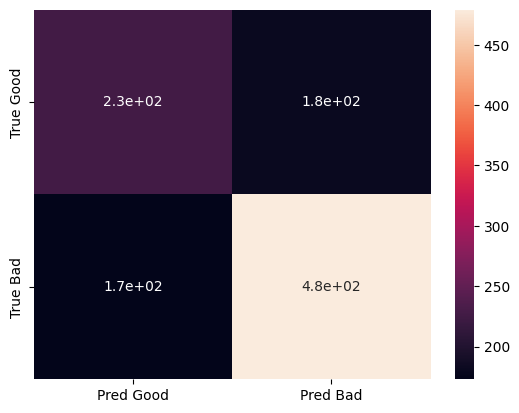

In [14]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Good', 'True Bad'],
                     ['Pred Good', 'Pred Bad'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [15]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/133272/models/wine_model/1


Model(name: 'wine_model', version: 1)